<a href="https://colab.research.google.com/github/camulro/Aprendizaje-II/blob/sesi%C3%B3n2/CNN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN con PyTorch - Ejemplo MNIST

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

In [ ]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                              ])

In [ ]:
trainset = datasets.MNIST('./mnist_data', download=True, train=True, transform=transform)
testset = datasets.MNIST('./mnist_data', download=True, train=False, transform=transform)

print(len(trainset))
print(len(testset))
batch_size=64

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...
Done!
60000
10000


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


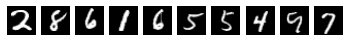

In [ ]:
figure = plt.figure()
num_of_images = 10
for index in range(1, num_of_images + 1):
    plt.subplot(1, 10, index)
    plt.axis('off')
    img = images[index]*0.3081 + 0.1307 # unnormalize
    plt.imshow(img.numpy().squeeze(), cmap='gray')
    


In [ ]:
print('GroundTruth: ', ' '.join('%s' % classes[labels[j]] for j in range(1,num_of_images + 1)))

GroundTruth:  2 8 6 1 6 5 5 4 9 7


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x): # x: (1x28x28)
        x = self.conv1(x)  # x: (32x26x26) ya que 28 pierde por arriba 1 y por abajo 1, por no tener padding, 32 es el num de canales
        x = F.relu(x) 
        x = self.conv2(x) # x: (64x24x24)
        x = F.relu(x)
        x = F.max_pool2d(x, 2) # x: (64x12x12)
        x = self.dropout1(x)
        x = torch.flatten(x, 1) # x: (64*12*12=9216)
        x = self.fc1(x) x: (128,1) 
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x) # x: (10,1) 
        return F.log_softmax(x, dim=1)

In [ ]:
model = Net()
model.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.NLLLoss()

In [ ]:
loss_list = []
accuracy_list = []

epochs = 5

for epoch in range(epochs):
   
    running_loss = 0
    # training our model
    for idx, (image, label) in enumerate(trainloader):
        image, label = image.to(device), label.to(device)
        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # Calculate accuracy
        total = label.size(0)
        _, prediction = torch.max(outputs, 1)
        correct = (prediction == label).sum().item()
        # The number of mini-batches in training set is 60000/64=937
        if idx % 100 == 99:    # print info every 100 mini-batches = 9 times per epoch
            loss_list.append(running_loss / 100) # average loss in 100 iterations
            accuracy_list.append(100 * correct / total)
            print('[%d, %5d] loss: %.3f, train acc: %d %%' %
                  (epoch + 1, idx + 1, running_loss / 100, 100 * correct / total))
            running_loss = 0.0 # reset every 100 mini-batches

print('Finished Training')

[1,   100] loss: 1.619, train acc: 65 %
[1,   200] loss: 0.677, train acc: 79 %
[1,   300] loss: 0.517, train acc: 79 %
[1,   400] loss: 0.447, train acc: 85 %
[1,   500] loss: 0.407, train acc: 96 %
[1,   600] loss: 0.393, train acc: 90 %
[1,   700] loss: 0.375, train acc: 89 %
[1,   800] loss: 0.325, train acc: 90 %
[1,   900] loss: 0.327, train acc: 89 %
[2,   100] loss: 0.312, train acc: 93 %
[2,   200] loss: 0.315, train acc: 90 %
[2,   300] loss: 0.283, train acc: 95 %
[2,   400] loss: 0.295, train acc: 89 %
[2,   500] loss: 0.284, train acc: 92 %
[2,   600] loss: 0.260, train acc: 93 %
[2,   700] loss: 0.270, train acc: 96 %
[2,   800] loss: 0.268, train acc: 96 %
[2,   900] loss: 0.254, train acc: 92 %
[3,   100] loss: 0.232, train acc: 96 %
[3,   200] loss: 0.237, train acc: 89 %
[3,   300] loss: 0.236, train acc: 92 %
[3,   400] loss: 0.223, train acc: 92 %
[3,   500] loss: 0.217, train acc: 92 %
[3,   600] loss: 0.209, train acc: 89 %
[3,   700] loss: 0.202, train acc: 95 %


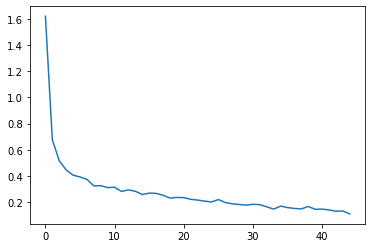

In [ ]:
plt.plot(np.array(loss_list))
plt.show()

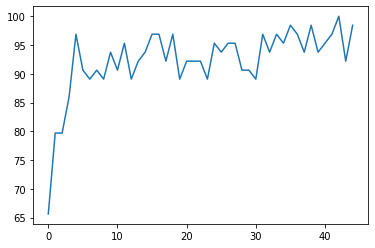

In [ ]:
plt.plot(np.array(accuracy_list))
plt.show()

In [ ]:
PATH = './mnist_net.pth'
torch.save(model.state_dict(), PATH)

GroundTruth:  8 1 8 2 6 6 7 1 3 9 9 1 9 9 2 7


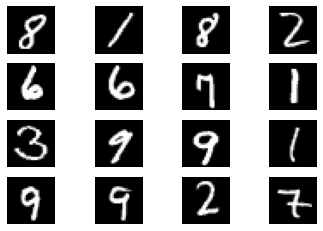

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)

# print images
figure = plt.figure()
num_of_images = 16
for index in range(1, num_of_images + 1):
    plt.subplot(4, 4, index)
    plt.axis('off')
    plt.imshow(images[index-1].cpu().numpy().squeeze(), cmap='gray')

print('GroundTruth: ', ' '.join('%s' % classes[labels[j]] for j in range(num_of_images)))

In [ ]:
outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%s' % classes[predicted[j]]
                              for j in range(num_of_images)))

Predicted:  8 1 8 2 6 6 7 1 3 9 9 1 9 9 2 7


In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 97 %


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of 0 : 99 %
Accuracy of 1 : 100 %
Accuracy of 2 : 97 %
Accuracy of 3 : 98 %
Accuracy of 4 : 98 %
Accuracy of 5 : 99 %
Accuracy of 6 : 98 %
Accuracy of 7 : 99 %
Accuracy of 8 : 97 %
Accuracy of 9 : 97 %
